# VRP - Vehicle Routing Problem
The Vehicle Routing Problem (VRP) is a classic combinatorial optimization problem in logistics and transportation, where the objective is to determine the most efficient routes for a fleet of vehicles to service a set of geographically distributed customers. Each vehicle starts and ends at a central depot, and the goal is typically to minimize total distance traveled, time, or delivery costs, while adhering to constraints such as vehicle capacity, time windows, and operational limits.

Originally formulated by Dantzig and Ramser in 1959 as an extension of the Traveling Salesman Problem (TSP), VRP has since become a foundational challenge in operations research, with applications spanning delivery services, waste collection, emergency response, and supply chain logistics.

This project implements a VRP model tailored to a fleet of trucks delivering orders across Japan. The model incorporates:
- **Realistic truck constraints**, such as capacity limits, travel speeds, hourly rates, and overnight fees.
- **Geographic order data**, including customer locations and package weights.
- **Route optimization logic**, built using constraint programming (via Google OR-Tools) and distance calculations based on the Haversine formula.
- **Cost modeling**, which accounts for delivery times, travel distances, hourly truck fees, and sleepover costs for long routes.

The dataset simulates a scenario where 20 customer orders are distributed across major cities in Japan, serviced by a fleet of trucks with varying capacities and cost structures. The problem seeks an optimal assignment of deliveries to trucks and an efficient set of routes that minimize the overall operational costs while ensuring feasibility.

## Problem overview
### Truck Constraints
Each truck in the fleet has unique characteristics:

|Truck Model	|Max Weight (kg)|	Average Speed (km/h)|	Hourly Fee (JPY)|	Sleepover Fee (JPY)|
|---|---|---|---|---|
|Shinkansen| 700|	2,000|	60|	4,500|	12,000|
|Toyota Dyna|	3,000|	50|	4,000|	10,000|
|Hino Ranger|	5,000|	45|	5,000|	15,000|

Additional considerations:
- Each trip starts and ends at the depot.
- Travel times include loading, unloading, and rest stops (overnight rest is mandatory for trips exceeding 8 hours).
- Costs are calculated based on hourly fees and additional sleepover charges.

### Dataset
The dataset includes:
- A list of customer orders, each with geographic coordinates (latitude and longitude) and package weights.
- A central depot (Tokyo) as the starting and ending point for all routes.

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.metrics.pairwise import haversine_distances
from ortools.sat.python import cp_model
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from copy import deepcopy

In [2]:
# Trucks
trucks = pd.DataFrame([
    {"truck_id": 1, "model": "Shinkansen 700", "max_weight_kg": 2000, "avg_speed_kmh": 60, "hourly_fee_jpy": 4500, "sleepover_fee_jpy": 12000},
    {"truck_id": 2, "model": "Toyota Dyna", "max_weight_kg": 3000, "avg_speed_kmh": 50, "hourly_fee_jpy": 4000, "sleepover_fee_jpy": 10000},
    {"truck_id": 3, "model": "Hino Ranger", "max_weight_kg": 5000, "avg_speed_kmh": 45, "hourly_fee_jpy": 5000, "sleepover_fee_jpy": 15000},
])
trucks.head()

,truck_id,model,max_weight_kg,avg_speed_kmh,hourly_fee_jpy,sleepover_fee_jpy
0,1,Shinkansen 700,2000,60,4500,12000
1,2,Toyota Dyna,3000,50,4000,10000
2,3,Hino Ranger,5000,45,5000,15000


In [3]:
# Orders
orders = pd.DataFrame([
    {"order_id": 101, "customer_name": "Sora Electronics", "latitude": 35.6895, "longitude": 139.6917, "package_weight_kg": 600},  # Tokyo (Shinjuku)
    {"order_id": 102, "customer_name": "Nippon Gadgets", "latitude": 35.7765, "longitude": 140.3180, "package_weight_kg": 1200},  # Narita (Chiba)
    {"order_id": 103, "customer_name": "Fuji Anime Store", "latitude": 35.3622, "longitude": 138.7310, "package_weight_kg": 1800},  # Mt. Fuji area
    {"order_id": 104, "customer_name": "Sakura Coffee", "latitude": 35.2271, "longitude": 138.8750, "package_weight_kg": 900},    # Shizuoka
    {"order_id": 105, "customer_name": "Kyoto Kimono Co.", "latitude": 35.0116, "longitude": 135.7681, "package_weight_kg": 700},  # Kyoto
    {"order_id": 106, "customer_name": "Hokkaido Seafood", "latitude": 43.0621, "longitude": 141.3544, "package_weight_kg": 2500}, # Sapporo
    {"order_id": 107, "customer_name": "Tokyo Tech Supplies", "latitude": 35.6895, "longitude": 139.6917, "package_weight_kg": 3000}, # Tokyo
    {"order_id": 108, "customer_name": "Osaka Tools", "latitude": 34.6937, "longitude": 135.5023, "package_weight_kg": 1300},     # Osaka
    {"order_id": 109, "customer_name": "Hiroshima Paper Co.", "latitude": 34.3853, "longitude": 132.4553, "package_weight_kg": 2200}, # Hiroshima
    {"order_id": 110, "customer_name": "Miyazaki Fruits", "latitude": 31.9111, "longitude": 131.4239, "package_weight_kg": 1500},  # Miyazaki
    {"order_id": 111, "customer_name": "Okinawa Beachwear", "latitude": 26.2124, "longitude": 127.6792, "package_weight_kg": 800},  # Okinawa
    {"order_id": 112, "customer_name": "Nagoya Robotics", "latitude": 35.1815, "longitude": 136.9066, "package_weight_kg": 1700},  # Nagoya
    {"order_id": 113, "customer_name": "Kagoshima Ceramics", "latitude": 31.5966, "longitude": 130.5571, "package_weight_kg": 1100}, # Kagoshima
    {"order_id": 114, "customer_name": "Kobe Sweets", "latitude": 34.6901, "longitude": 135.1955, "package_weight_kg": 1400},      # Kobe
    {"order_id": 115, "customer_name": "Sendai Electronics", "latitude": 38.2682, "longitude": 140.8694, "package_weight_kg": 2300}, # Sendai
    {"order_id": 116, "customer_name": "Yokohama Maritime", "latitude": 35.4437, "longitude": 139.6380, "package_weight_kg": 1800}, # Yokohama
    {"order_id": 117, "customer_name": "Nagano Outdoors", "latitude": 36.6513, "longitude": 138.1810, "package_weight_kg": 950},   # Nagano
    {"order_id": 118, "customer_name": "Fukuoka Fashion", "latitude": 33.5902, "longitude": 130.4017, "package_weight_kg": 2000},  # Fukuoka
    {"order_id": 119, "customer_name": "Kumamoto Textiles", "latitude": 32.7898, "longitude": 130.7417, "package_weight_kg": 1250}, # Kumamoto
    {"order_id": 120, "customer_name": "Akita Crafts", "latitude": 39.7200, "longitude": 140.1025, "package_weight_kg": 1350},     # Akita
])
orders.head(10)

,order_id,customer_name,latitude,longitude,package_weight_kg
0,101,Sora Electronics,35.6895,139.6917,600
1,102,Nippon Gadgets,35.7765,140.3180,1200
2,103,Fuji Anime Store,35.3622,138.7310,1800
3,104,Sakura Coffee,35.2271,138.8750,900
4,105,Kyoto Kimono Co.,35.0116,135.7681,700
5,106,Hokkaido Seafood,43.0621,141.3544,2500
6,107,Tokyo Tech Supplies,35.6895,139.6917,3000
7,108,Osaka Tools,34.6937,135.5023,1300
8,109,Hiroshima Paper Co.,34.3853,132.4553,2200
9,110,Miyazaki Fruits,31.9111,131.4239,1500


In [4]:
# Origin
depot = {"latitude": 35.698353, "longitude": 139.773114}

In [5]:
# Build a full graph
G = nx.complete_graph(len(orders) + 1)

# Add the origin coordinates
origin_node = G.nodes()[0]
origin_node["coords"] = (depot["latitude"], depot["longitude"])
origin_node["demand"] = 0

# Assign coordinates and demand to the nodes
for idx, order in orders.iterrows():
    G.nodes[idx + 1]["coords"] = tuple(order[["latitude", "longitude"]])
    G.nodes[idx + 1]["demand"] = int(order["package_weight_kg"])

# Calculate the distances
for u in G.nodes:
    for v in G.nodes:
        if u != v:
            coord0 = np.radians(G.nodes[u]["coords"]).reshape((1, -1))
            coord1 = np.radians(G.nodes[v]["coords"]).reshape((1, -1))
            distance = 6371.0 * haversine_distances(coord0, coord1).item()
            G[u][v]["distance"] = distance


# Create a graph for each truck
trucks_graphs = []
for _, truck in trucks.iterrows():
    # Make a copy
    G_copy = deepcopy(G)

    # Add the truck data
    for u in G_copy.nodes:
        for v in G_copy.nodes:
            if u != v:
                distance = G_copy[u][v]["distance"]
                # Travel time
                travel_time = 1.05 * distance / truck["avg_speed_kmh"] # 5% margin
                # Loading the truck
                if u == 0:
                    travel_time += 1 # 1 hour
                # Delivery time
                if v == 0:
                    travel_time += 0.5 # half hour for deloading the truck
                # Count of stops to sleep
                n_stops = travel_time // 8
                # sleepover cost
                sleepover_cost = n_stops * truck["sleepover_fee_jpy"]
                # Total cost
                delivery_cost = truck["hourly_fee_jpy"] * travel_time
                # Add the data
                G_copy[u][v]["travel_time"] = travel_time
                G_copy[u][v]["delivery_cost"] = delivery_cost + sleepover_cost
                G_copy[u][v]["n_stops"] = n_stops
    
    trucks_graphs.append(G_copy)

In [6]:
class SolutionCallback(cp_model.CpSolverSolutionCallback):
    """A simple solution printer"""
    def __init__(self, objective_expr: cp_model.LinearExprT):
        super().__init__()
        self.objective_expr = objective_expr
        self.solution_count = 0

    def on_solution_callback(self):
        """Reports on every solution found"""
        self.solution_count += 1
        objective_value = self.value(self.objective_expr)
        print(f"Solution {self.solution_count}: {objective_value:,.0f}")

In [7]:
solver = cp_model.CpSolver()
model = cp_model.CpModel()

# Create the arc vars for teh multiple circuit constraint
arc_vars = {}
for u in G.nodes:
    for v in G.nodes:
        if u != v:
            arc_vars[u, v] = model.new_bool_var(f"{u}_{v}")

# Add a multiple circuit constraint
model.add_multiple_circuit([(u, v, var) for (u, v), var in arc_vars.items()])

# Constrain each arc var to a single truck
truck_arc_vars = {}
for t in range(len(trucks)):
    for u in G.nodes:
        for v in G.nodes:
            if u != v:
                truck_arc_vars[t, u, v] = model.new_bool_var(f"{t}_{u}_{v}")

for (u, v), var in arc_vars.items():
    truck_vars = [truck_arc_vars[t, u, v] for t in range(len(trucks))]
    model.add(sum(truck_vars) == 1).only_enforce_if(var)
    model.add(sum(truck_vars) == 0).only_enforce_if(var.Not())

# Ensures all trucks are used at least once
for t in range(len(trucks)):
    arcs_used = [truck_arc_vars[t, u, v] for u in G.nodes for v in G.nodes if u != v]
    model.add(sum(arcs_used) >= 1)

# Flow conservation per truck
for t in range(len(trucks)):
    for n in G.nodes:
        inflow = [truck_arc_vars[t, u, n] for u in G.nodes if u != n]
        outflow = [truck_arc_vars[t, n, v] for v in G.nodes if v != n]
        model.add(sum(inflow) == sum(outflow))

# Capacity constraint
cap_vars = {}
for t, truck in trucks.iterrows():
    for n in G.nodes:
        cap_vars[t, n] = model.new_int_var(0, truck["max_weight_kg"], f"{t}_{n}_cap")

# ALlow multiple trips per truck
for (t, u, v), var in truck_arc_vars.items():
    demand = G.nodes[v]["demand"]
    # If a truck visit a node the demand increases
    if v != 0:
        model.add(cap_vars[t, v] >= cap_vars[t, u] + demand).only_enforce_if(var)
    # If a truck returns to the depot the capacity is reset
    else:
        model.add(cap_vars[t, v] == 0).only_enforce_if(var)
        
delivery_cost = sum(int(trucks_graphs[t][u][v]["delivery_cost"]) * var for (t, u, v), var in truck_arc_vars.items())
model.minimize(delivery_cost)

solver.parameters.max_time_in_seconds = 30
solver.parameters.random_seed = 42
solution_callback = SolutionCallback(delivery_cost)
solver.solve(model, solution_callback=solution_callback)
solver.status_name()

Solution 1: 1,849,063
Solution 2: 1,809,300
Solution 3: 1,807,914
Solution 4: 1,498,999
Solution 5: 1,496,195
Solution 6: 1,476,315
Solution 7: 1,475,951
Solution 8: 1,455,183
Solution 9: 1,446,621
Solution 10: 1,442,194
Solution 11: 1,442,018
Solution 12: 1,436,772
Solution 13: 1,436,060
Solution 14: 1,430,687
Solution 15: 1,406,892
Solution 16: 1,405,563
Solution 17: 1,372,261
Solution 18: 1,370,731
Solution 19: 1,332,883
Solution 20: 1,313,352
Solution 21: 1,312,033
Solution 22: 1,305,308
Solution 23: 1,294,617
Solution 24: 1,287,892
Solution 25: 1,281,256
Solution 26: 1,279,657
Solution 27: 1,269,077
Solution 28: 1,269,022
Solution 29: 1,267,643
Solution 30: 1,265,918
Solution 31: 1,265,917
Solution 32: 1,264,659
Solution 33: 1,264,483
Solution 34: 1,254,511
Solution 35: 1,254,335
Solution 36: 1,253,006
Solution 37: 1,250,315
Solution 38: 1,249,803
Solution 39: 1,247,236
Solution 40: 1,245,706
Solution 41: 1,245,702
Solution 42: 1,244,103


'FEASIBLE'

In [8]:
# Extract the solution as a directed graph
G_solution = nx.DiGraph()
# Add nodes
for n in G.nodes:
    G_solution.add_node(n, **G.nodes[n])
# Fill edges with solutions
for (t, u, v), var in truck_arc_vars.items():
    if solver.value(var):
        G_solution.add_edge(u, v, **trucks_graphs[t][u][v])
        # Add the truck
        G_solution[u][v]["truck"] = t

In [9]:
# View edges
G_solution.edges

OutEdgeView([(0, 2), (0, 4), (0, 6), (0, 1), (0, 5), (0, 15), (0, 16), (0, 19), (1, 12), (2, 0), (3, 0), (4, 3), (5, 9), (6, 0), (7, 0), (8, 0), (9, 18), (10, 0), (11, 10), (12, 14), (13, 11), (14, 8), (15, 20), (16, 7), (17, 0), (18, 0), (19, 13), (20, 17)])

In [10]:
def create_tour_graphs(g: nx.DiGraph, source=0) -> list[nx.DiGraph]:
    """Create individual directed graphs for each circuit"""
    # Holds a list for each tour
    tours_list = []
    # Initial tour
    curr_tour = []
    for u, v in nx.eulerian_circuit(g, source=source):
        curr_tour.append((u, v))
        if v == 0: # Start a new tour
            if curr_tour:
                tours_list.append(curr_tour)
                # reset the current tour
                curr_tour = []

    tours_graphs = []
    for tour in tours_list:
        tg = nx.DiGraph()
        # Add the nodes
        for n in set([n for e in tour for n in e]):
            tg.add_node(n, **g.nodes[n])
        # Add the edges
        for (u, v) in tour:
            tg.add_edge(u, v, **g[u][v])
        tours_graphs.append(tg)
    return tours_graphs

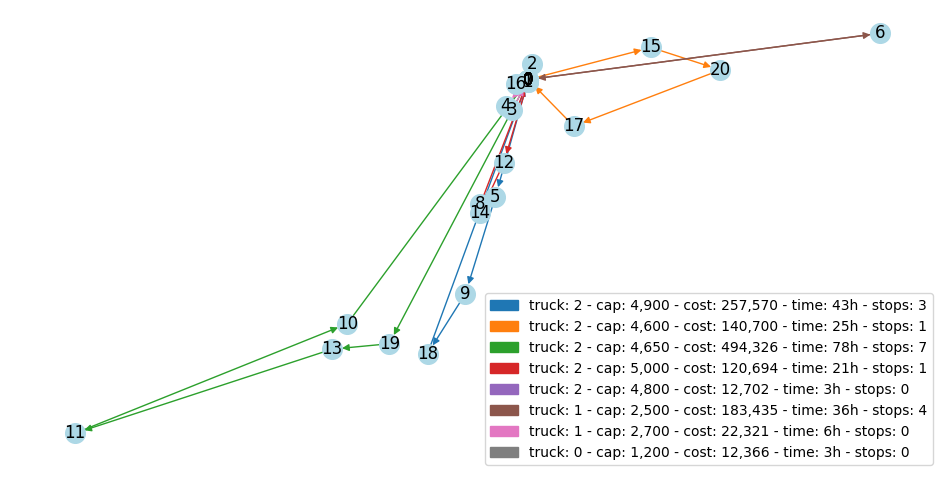

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))

# Legend patches
legend_patches = []

# colors
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the tours
for tour, color in zip(create_tour_graphs(G_solution), colors):
    pos = nx.get_node_attributes(tour, "coords")
    nx.draw(tour, 
            pos, 
            with_labels=True,
            node_color="lightblue",
            arrows=True, 
            edge_color=color,
            node_size=200,
            ax=ax)

    # Add legend data
    truck = list(set(tour[u][v]["truck"] for (u, v) in tour.edges))[0]
    demand = sum(tour.nodes[n]["demand"] for n in tour.nodes)
    cost = sum(tour[u][v]["delivery_cost"] for (u, v) in tour.edges)
    time = sum(tour[u][v]["travel_time"] for (u, v) in tour.edges)
    stops = int(sum(tour[u][v]["n_stops"] for (u, v) in tour.edges))
    legend_patches.append(
        mpatches.Patch(color=color, label=f"truck: {truck} - cap: {demand:,.0f} - cost: {cost:,.0f} - time: {time:.0f}h - stops: {stops}")
    )

# Add the legend
ax.legend(handles=legend_patches)
plt.show()